# Stock Price Prediction

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(8, 7))
mpl.__version__
# Adjusting the style of matplotlib
style.use('ggplot')
import math
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

### Load Data

In [2]:
# Set start and end dates
start = datetime.datetime(2017, 9, 1)
end = datetime.datetime(2019, 8, 31)

# Download data from Yahoo Finance
df = web.DataReader("IFC.TO", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-26,127.730003,125.449997,125.910004,127.419998,390200.0,127.419998
2019-08-27,130.309998,127.690002,127.889999,130.210007,374000.0,130.210007
2019-08-28,130.070007,128.080002,129.830002,129.979996,319800.0,129.979996
2019-08-29,130.570007,129.570007,130.169998,129.679993,178500.0,129.679993
2019-08-30,130.580002,129.309998,129.899994,130.119995,280600.0,130.119995


### Moving Averages

In [3]:
# Get adjusted close prices
close_px = df['Adj Close']

# Define number of days for moving average
mavg_days = 100

# Calculate moving average
mavg = close_px.rolling(window=mavg_days).mean()

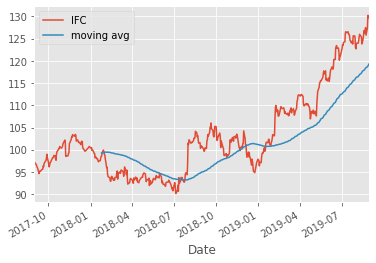

In [4]:
# Plot moving averages
close_px.plot(label='IFC')
mavg.plot(label='moving avg')
plt.legend()

### Returns

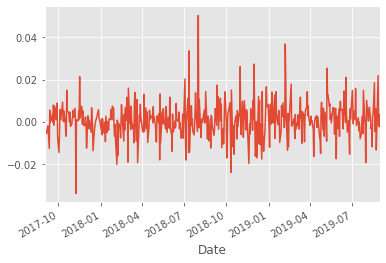

In [5]:
# Calculate and plot returns
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

### Competitor Analysis

In [6]:
# Get data for competitor stocks - Allstate, 
dfcomp = web.DataReader(['IFC.TO','ALL','TD','RY','BNS'],'yahoo',start=start,end=end)['Adj Close']
dfcomp.head()

Symbols,ALL,BNS,IFC.TO,RY,TD
Date,,,,,
2017-09-01,86.366280,55.800129,97.197327,66.789879,49.578854
2017-09-05,83.201370,55.097065,96.666656,65.882339,49.187683
2017-09-06,84.172966,55.746735,96.287590,66.753944,49.533363
2017-09-07,83.162888,55.791225,96.031738,67.032486,49.724400
2017-09-08,86.202751,55.800129,95.842209,66.969589,49.551559


#### Correlation Analysis

Text(0, 0.5, 'Returns TD')

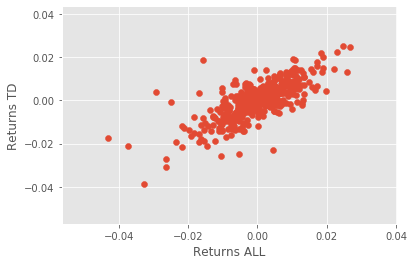

In [7]:
# Returns
retscomp = dfcomp.pct_change()
# Correlations
corr = retscomp.corr()
# Plot
plt.scatter(retscomp.BNS, retscomp.TD)
plt.xlabel('Returns ALL')
plt.ylabel('Returns TD')

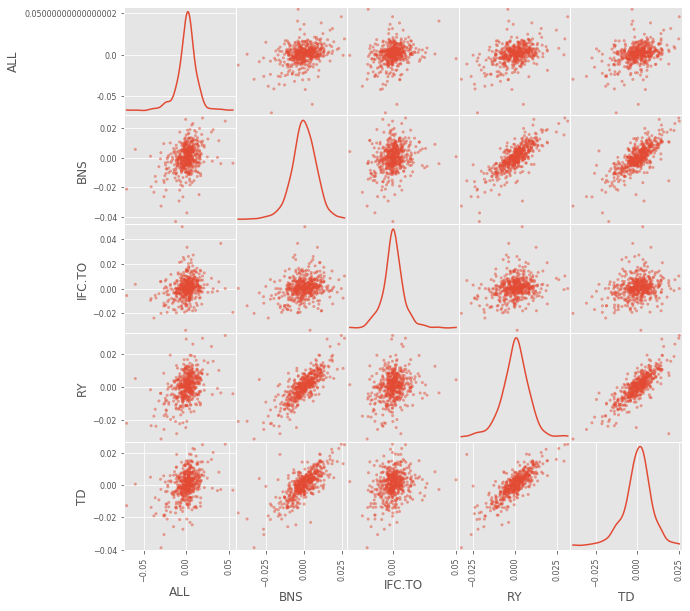

In [8]:
# Create scatterplot
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

#### Heatmap

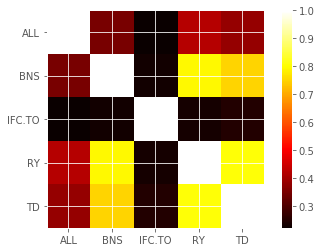

In [9]:
# Create correlation heatmap
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

### Predicting Stocks Price

#### Feature Engineering

In [10]:
# High - low percentages
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2017-09-01,97.197327,146800.0,0.643459,-0.107130
2017-09-05,96.666656,288300.0,0.627389,-0.263978
2017-09-06,96.287590,168100.0,1.033358,-0.596753
2017-09-07,96.031738,190400.0,0.651277,-0.265726
2017-09-08,95.842209,209100.0,0.810757,-0.295744


#### Pre-processing & Cross Validation

In [11]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

### Simple Linear Analysis & Quadratic Discriminant Analysis

In [12]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X, y)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X, y)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X, y)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

### K Nearest Neighbor (KNN)

In [13]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

### Forecasting

In [14]:
# Make predictions
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

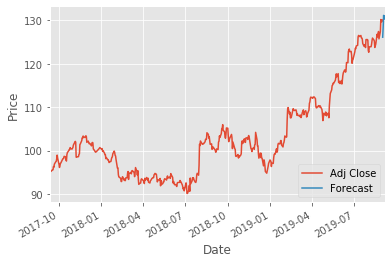

In [15]:
# Plot
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()